## Experimentation with Privacy Tree: Reproducing Results from the Paper


This notebook provides a way to reproduce the experiment described in the paper [Privacy-Preserving Tree-Based Inference with Fully Homomorphic Encryption](https://arxiv.org/pdf/2303.01254.pdf). By following the instructions in this notebook, users can run the experiment themselves and verify the results reported in the paper.

In [1]:
# Importing necessary libraries and modules

import time

import numpy as np
from IPython.display import display
from onnx import numpy_helper
from sklearn.datasets import fetch_openml
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelBinarizer, OrdinalEncoder

from concrete.ml.sklearn import DecisionTreeClassifier, RandomForestClassifier, XGBClassifier


def basic_preprocessing(df, target_column):
    """
    Convert categorical columns to their corresponding code values
    and binarize the target column.

    Parameters:
        df (pandas.DataFrame): Input dataframe to preprocess.
        target_column (str): Name of the target column to be binarized.

    Returns:
        pandas.DataFrame: Preprocessed dataframe.
    """

    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].astype("category")
            df[col] = df[col].cat.codes
        elif df[col].dtype == "category":
            df[col] = df[col].cat.codes
    df[target_column] = LabelBinarizer().fit_transform(df[target_column])

    return df

In [2]:
# Set up dataset names and their respective IDs for fetching from OpenML
dataset_names = {
    "spambase": 44,
    "wine": None,
    "heart-h": 1565,
    "wdbc": 1510,
    "adult": None,
    "steel": 1504,
}

datasets = {}


def load_dataset(name, data_id=None):
    """Load dataset from OpenML by name or by ID.

    Args:
        name (str): Name of the dataset.
        data_id (int, optional): The ID of the dataset on OpenML.
            If provided, the dataset is loaded by ID.

    Returns:
        X (np.array): Features of the dataset.
        y (np.array): Target labels of the dataset.
    """
    if data_id is not None:
        X, y = fetch_openml(data_id=data_id, as_frame=False, cache=True, return_X_y=True)
    else:
        X, y = fetch_openml(name=name, as_frame=False, cache=True, return_X_y=True)
    return X, y


for ds_name, ds_id in dataset_names.items():
    print(f"Loading {ds_name}")

    X, y = load_dataset(ds_name, ds_id)

    # Remove rows with NaN values
    not_nan_idx = np.where(~np.isnan(X).any(axis=1))
    X = X[not_nan_idx]
    y = y[not_nan_idx]

    # Convert non-integer target labels to integers
    if not y.dtype == np.int64:
        encoder = OrdinalEncoder()
        y = encoder.fit_transform(y.reshape(-1, 1)).astype(np.int32).squeeze()

    datasets[ds_name] = {"X": X, "y": y}

Loading spambase
Loading wine


Loading heart-h


Loading wdbc


Loading adult


Loading steel


In [3]:
# Setting a random seed for reproducibility across all models and operations
random_seed = 42

# Models with their hyper-parameters
model_hyperparameters = {
    DecisionTreeClassifier: {"max_depth": 5, "random_state": random_seed},
    XGBClassifier: {"max_depth": 3, "n_estimators": 50, "random_state": random_seed},
    RandomForestClassifier: {"n_estimators": 50, "random_state": random_seed},
}

decision_tree_comparison_params = {
    "spam": {"max_leaf_nodes": 58, "max_depth": 17},
    "heart-h": {"max_leaf_nodes": 5, "max_depth": 3},
    "steel": {"max_leaf_nodes": None, "max_depth": 5},
    "wdbc": {"max_leaf_nodes": None, "max_depth": 10},
}

# List of bit-width used for quantization
n_bits_list = list(range(1, 10))

In [4]:
def analyze_gemm_computation(concrete_classifier):
    """Analyze the GEMM (General Matrix Multiply) operations in the given ONNX model.

    Args:
        concrete_classifier (object): Classifier that contains an ONNX model representation.
        x_train (np.array): Training dataset.

    Returns:
        tuple: Shapes of the matrices involved in GEMM operations.
    """

    # Extract weights and biases from the ONNX model graph
    quant_params = {
        onnx_init.name: numpy_helper.to_array(onnx_init)
        for onnx_init in concrete_classifier.onnx_model.graph.initializer
        if "weight" in onnx_init.name or "bias" in onnx_init.name
    }

    # Extract the shapes of matrices used in GEMM operations
    matrix_shapes = []
    for i in range(1, 4):
        key = [key for key in quant_params.keys() if f"_{i}" in key and "weight" in key][0]
        matrix_shapes.append(quant_params[key].shape)

    return tuple(matrix_shapes)

# Experiments for table 1

In [5]:
def benchmark_model(X, y, model, model_params, n_bits, rkf):
    """Benchmark a given model and return its evaluation scores."""
    scores = {
        "precision": [],
        "recall": [],
        "accuracy": [],
        "f1": [],
        "average_precision": [],
        "nodes": None,
    }
    scores_fp32 = {"precision": [], "recall": [], "accuracy": [], "f1": [], "average_precision": []}

    metric_func_to_key = {
        "precision_score": "precision",
        "recall_score": "recall",
        "f1_score": "f1",
        "average_precision_score": "average_precision",
    }

    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        concrete_model, sklearn_model = model(n_bits=n_bits, **model_params).fit_benchmark(
            X_train, y_train
        )

        y_pred = concrete_model.predict(X_test)
        if len(set(y_test)) == 2:
            for metric_func in [precision_score, recall_score, average_precision_score, f1_score]:
                scores_key = metric_func_to_key[metric_func.__name__]
                scores[scores_key].append(metric_func(y_test, y_pred))
        scores["accuracy"].append(accuracy_score(y_test, y_pred))

        y_pred_fp32 = sklearn_model.predict(X_test)
        if len(set(y_test)) == 2:
            for metric_func in [precision_score, recall_score, average_precision_score, f1_score]:
                scores_key = metric_func_to_key[metric_func.__name__]
                scores_fp32[scores_key].append(metric_func(y_test, y_pred_fp32))
        scores_fp32["accuracy"].append(accuracy_score(y_test, y_pred_fp32))

        shapes = analyze_gemm_computation(concrete_model)
        scores["nodes"] = shapes[0][0]

    # Calculate inference time
    concrete_model.compile(X_train)
    concrete_model.fhe_circuit.keygen(force=False)

    start = time.time()
    concrete_model.predict(X_test[:1], fhe="execute")
    end = time.time()
    scores["inference_time"] = end - start

    start = time.time()
    concrete_model.predict(X_test[:1])
    end = time.time()
    scores_fp32["inference_time"] = end - start

    return scores, scores_fp32


n_bits = 6
scores_global = {}

rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)

for dataset_name, dataset_data in datasets.items():
    X, y = dataset_data["X"].astype(np.float32), dataset_data["y"]
    assert len(set(y)) >= 2
    if y.dtype not in [np.int32, np.bool]:
        print(f"Unexpected datatype for y in dataset {dataset_name}: {y.dtype}")

    key_dataset = f"{dataset_name} (#features: {X.shape[1]})"
    scores_global[key_dataset] = {}

    for cls, model_params in model_hyperparameters.items():
        scores, scores_fp32 = benchmark_model(X, y, cls, model_params, n_bits, rkf)

        scores_global[key_dataset][cls.__name__ + "_concrete"] = scores
        scores_global[key_dataset][cls.__name__ + "_fp32"] = scores_fp32

        print(
            f"{cls.__name__} on {key_dataset} -> Acc: {np.mean(scores['accuracy']):.4f}, "
            f"Acc (fp32): {np.mean(scores_fp32['accuracy']):.4f}, "
            f"FHE inference time: {scores['inference_time']:.2f}s"
        )

DecisionTreeClassifier on spambase (#features: 57) -> Acc: 0.9103, Acc (fp32): 0.9035, FHE inference time: 1.22s


XGBClassifier on spambase (#features: 57) -> Acc: 0.9448, Acc (fp32): 0.9497, FHE inference time: 1.05s


RandomForestClassifier on spambase (#features: 57) -> Acc: 0.9089, Acc (fp32): 0.9184, FHE inference time: 1.74s


DecisionTreeClassifier on wine (#features: 13) -> Acc: 0.9083, Acc (fp32): 0.9046, FHE inference time: 0.53s


XGBClassifier on wine (#features: 13) -> Acc: 0.9699, Acc (fp32): 0.9624, FHE inference time: 1.77s


RandomForestClassifier on wine (#features: 13) -> Acc: 0.9850, Acc (fp32): 0.9813, FHE inference time: 1.34s


DecisionTreeClassifier on heart-h (#features: 13) -> Acc: 0.6100, Acc (fp32): 0.5998, FHE inference time: 0.69s


XGBClassifier on heart-h (#features: 13) -> Acc: 0.6543, Acc (fp32): 0.6463, FHE inference time: 3.15s


RandomForestClassifier on heart-h (#features: 13) -> Acc: 0.6679, Acc (fp32): 0.6644, FHE inference time: 1.71s


DecisionTreeClassifier on wdbc (#features: 30) -> Acc: 0.9420, Acc (fp32): 0.9391, FHE inference time: 0.60s


XGBClassifier on wdbc (#features: 30) -> Acc: 0.9678, Acc (fp32): 0.9649, FHE inference time: 0.97s


RandomForestClassifier on wdbc (#features: 30) -> Acc: 0.9561, Acc (fp32): 0.9526, FHE inference time: 1.58s


DecisionTreeClassifier on adult (#features: 14) -> Acc: 0.8364, Acc (fp32): 0.8364, FHE inference time: 0.66s


XGBClassifier on adult (#features: 14) -> Acc: 0.8535, Acc (fp32): 0.8543, FHE inference time: 1.01s


RandomForestClassifier on adult (#features: 14) -> Acc: 0.8341, Acc (fp32): 0.8341, FHE inference time: 1.76s


DecisionTreeClassifier on steel (#features: 33) -> Acc: 0.9717, Acc (fp32): 0.9717, FHE inference time: 0.57s


XGBClassifier on steel (#features: 33) -> Acc: 1.0000, Acc (fp32): 1.0000, FHE inference time: 0.65s


RandomForestClassifier on steel (#features: 33) -> Acc: 0.9687, Acc (fp32): 0.9586, FHE inference time: 1.88s


In [6]:
import math

import pandas as pd

df = pd.DataFrame.from_dict(
    {(i, j): value for i, scores in scores_global.items() for j, value in scores.items()},
    orient="index",
)


df["FHE/Clear ratio"] = (df["inference_time"] / df["inference_time"].shift(-1)).apply(
    lambda x: "" if (x < 1) or (math.isnan(x)) else str(int(round(x, 0))) + "x"
)


def format_scores(val):
    if isinstance(val, list):
        if not val:
            return "-"
        return f"{np.mean(val) * 100:.1f}\\% ± {np.std(val) * 100:.1f}\\%"

    if pd.isna(val):
        return "-"

    if isinstance(val, (float, int)):
        # To ensure all floating point values are treated as percentages
        return f"{val:.3f}"

    if "x" in str(val):  # Ensure that val is treated as a string
        return val

    return "-"


df = df.applymap(format_scores)

# Renaming for display
model_names = {
    "DecisionTreeClassifier_concrete": "FHE-DT",
    "DecisionTreeClassifier_fp32": "FP32-DT",
    "XGBClassifier_concrete": "FHE-XGB",
    "XGBClassifier_fp32": "FP32-XGB",
    "RandomForestClassifier_concrete": "FHE-RF",
    "RandomForestClassifier_fp32": "FP32-RF",
}

for original, renamed in model_names.items():
    df.index = df.index.set_levels(df.index.levels[1].str.replace(original, renamed), level=1)

df.columns = df.columns.str.replace("average_precision", "AP")

# Reordering Columns
columns_order = [col for col in df if col not in ["FHE/Clear ratio", "inference_time"]] + [
    "inference_time",
    "FHE/Clear ratio",
]
df = df[columns_order]

# Drop and rename columns
df.columns = df.columns.str.replace("inference_time", "Time (s)")
df.drop(columns=["precision", "recall"], inplace=True)

# Adjust LaTeX output
latex_code = df.to_latex(multirow=True, escape=False, column_format="l|l|l|l|l|l|l|l")

latex_code = latex_code.replace("#", "\\#")
display(df)

accuracy               f1  \
spambase (#features: 57) FHE-DT     91.0\% ± 1.0\%   88.0\% ± 1.3\%   
                         FP32-DT    90.3\% ± 1.0\%   87.4\% ± 1.2\%   
                         FHE-XGB    94.5\% ± 0.8\%   92.9\% ± 1.1\%   
                         FP32-XGB   95.0\% ± 0.7\%   93.6\% ± 0.9\%   
                         FHE-RF     90.9\% ± 1.1\%   87.5\% ± 1.5\%   
                         FP32-RF    91.8\% ± 1.1\%   89.0\% ± 1.4\%   
wine (#features: 13)     FHE-DT     90.8\% ± 5.2\%                -   
                         FP32-DT    90.5\% ± 5.0\%                -   
                         FHE-XGB    97.0\% ± 2.4\%                -   
                         FP32-XGB   96.2\% ± 2.9\%                -   
                         FHE-RF     98.5\% ± 1.4\%                -   
                         FP32-RF    98.1\% ± 2.0\%                -   
heart-h (#features: 13)  FHE-DT     61.0\% ± 5.4\%                -   
                         FP32-DT    60.0\% ± 5.5\%                -   
                         FHE-XGB    65.4\% ± 7.8\%                -   
                         FP32-XGB   64.6\% ± 7.5\%                -   
                         FHE-RF     66.8\% ± 6.4\%                -   
                         FP32-RF    66.4\% ± 5.3\%                -   
wdbc (#features: 30)     FHE-DT     94.2\% ± 1.9\%   92.0\% ± 2.8\%   
                         FP32-DT    93.9\% ± 1.9\%   91.7\% ± 3.0\%   
                         FHE-XGB    96.8\% ± 1.1\%   95.5\% ± 1.8\%   
                         FP32-XGB   96.5\% ± 1.6\%   95.2\% ± 2.4\%   
                         FHE-RF     95.6\% ± 1.7\%   93.9\% ± 2.6\%   
                         FP32-RF    95.3\% ± 1.8\%   93.4\% ± 2.9\%   
adult (#features: 14)    FHE-DT     83.6\% ± 0.4\%   60.4\% ± 0.7\%   
                         FP32-DT    83.6\% ± 0.4\%   60.4\% ± 0.7\%   
                         FHE-XGB    85.3\% ± 0.2\%   67.3\% ± 0.7\%   
                         FP32-XGB   85.4\% ± 0.2\%   67.8\% ± 0.4\%   
                         FHE-RF     83.4\% ± 0.4\%   57.6\% ± 1.1\%   
                         FP32-RF    83.4\% ± 0.4\%   57.6\% ± 1.2\%   
steel (#features: 33)    FHE-DT     97.2\% ± 0.7\%   96.1\% ± 0.9\%   
                         FP32-DT    97.2\% ± 0.7\%   96.1\% ± 0.9\%   
                         FHE-XGB   100.0\% ± 0.0\%  100.0\% ± 0.0\%   
                         FP32-XGB  100.0\% ± 0.0\%  100.0\% ± 0.0\%   
                         FHE-RF     96.9\% ± 1.2\%   95.4\% ± 1.8\%   
                         FP32-RF    95.9\% ± 1.1\%   93.9\% ± 1.5\%   

                                                AP     nodes Time (s)  \
spambase (#features: 57) FHE-DT     84.3\% ± 1.7\%    23.000    1.217   
                         FP32-DT    82.4\% ± 1.8\%         -    0.002   
                         FHE-XGB    89.6\% ± 1.4\%   350.000    1.052   
                         FP32-XGB   90.5\% ± 1.1\%         -    0.002   
                         FHE-RF     84.6\% ± 1.7\%   750.000    1.740   
                         FP32-RF    86.0\% ± 1.6\%         -    0.002   
wine (#features: 13)     FHE-DT                  -     7.000    0.526   
                         FP32-DT                 -         -    0.001   
                         FHE-XGB                 -   900.000    1.771   
                         FP32-XGB                -         -    0.002   
                         FHE-RF                  -   500.000    1.338   
                         FP32-RF                 -         -    0.002   
heart-h (#features: 13)  FHE-DT                  -    21.000    0.691   
                         FP32-DT                 -         -    0.001   
                         FHE-XGB                 -  1750.000    3.149   
                         FP32-XGB                -         -    0.002   
                         FHE-RF                  -   750.000    1.707   
                         FP32-RF                 -         -    0.001   
wdbc (#features: 30)     FH

# Experiments Figure 2. - Impact of the precision

In [7]:
def evaluate_model(X, y, model, rkf):
    """Evaluate a given model and return its scores."""
    scores = {"precision": [], "recall": [], "accuracy": [], "f1": [], "average_precision": []}
    scores_fp32 = {"precision": [], "recall": [], "accuracy": [], "f1": [], "average_precision": []}

    metric_func_to_key = {
        "precision_score": "precision",
        "recall_score": "recall",
        "f1_score": "f1",
        "average_precision_score": "average_precision",
    }

    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        concrete_model, sklearn_model = model.fit_benchmark(X_train, y_train)

        for model_instance, score_dict in [(concrete_model, scores), (sklearn_model, scores_fp32)]:
            y_pred = model_instance.predict(X_test)
            for metric_func in [precision_score, recall_score, average_precision_score, f1_score]:
                score_key = metric_func_to_key[metric_func.__name__]
                score_dict[score_key].append(metric_func(y_test, y_pred))
            score_dict["accuracy"].append(accuracy_score(y_test, y_pred))

    return scores, scores_fp32


rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
X, y = datasets["spambase"]["X"].astype(np.float32), datasets["spambase"]["y"]
assert len(set(y)) == 2
if y.dtype not in [np.int32, np.bool]:
    print(f"Unexpected datatype for y in dataset spambase: {y.dtype}")

scores_global = {}

for n_bits in n_bits_list:
    scores_global[n_bits] = {}

    for model_cls, params in model_hyperparameters.items():
        model_instance = model_cls(n_bits=n_bits, **params)
        scores, scores_fp32 = evaluate_model(X, y, model_instance, rkf)

        model_name = model_cls.__name__
        scores_global[n_bits][model_name + "_concrete"] = scores
        scores_global[n_bits][model_name + "_fp32"] = scores_fp32

        print(f"{model_name} with {n_bits}-bits:")
        print("Average precision:", np.mean(scores["average_precision"]))
        print("Average precision (fp32):", np.mean(scores_fp32["average_precision"]))

DecisionTreeClassifier with 1-bits:
Average precision: 0.408932530057913
Average precision (fp32): 0.8240131348716936


XGBClassifier with 1-bits:
Average precision: 0.39404467418842154
Average precision (fp32): 0.9046696576909921


RandomForestClassifier with 1-bits:
Average precision: 0.39404467418842154
Average precision (fp32): 0.8601540794231147


DecisionTreeClassifier with 2-bits:
Average precision: 0.5783561241072402
Average precision (fp32): 0.8240131348716936


XGBClassifier with 2-bits:
Average precision: 0.6247177037498485
Average precision (fp32): 0.9046696576909921


RandomForestClassifier with 2-bits:
Average precision: 0.5692185974635017
Average precision (fp32): 0.8601540794231147


DecisionTreeClassifier with 3-bits:
Average precision: 0.6809716709773868
Average precision (fp32): 0.8240131348716936


XGBClassifier with 3-bits:
Average precision: 0.7950698031111193
Average precision (fp32): 0.9046696576909921


RandomForestClassifier with 3-bits:
Average precision: 0.7371651377079289
Average precision (fp32): 0.8601540794231147


DecisionTreeClassifier with 4-bits:
Average precision: 0.733924323832143
Average precision (fp32): 0.8240131348716936


XGBClassifier with 4-bits:
Average precision: 0.8521287716294133
Average precision (fp32): 0.9046696576909921


RandomForestClassifier with 4-bits:
Average precision: 0.8056925848877744
Average precision (fp32): 0.8601540794231147


DecisionTreeClassifier with 5-bits:
Average precision: 0.8101306169806723
Average precision (fp32): 0.8240131348716936


XGBClassifier with 5-bits:
Average precision: 0.878407427344724
Average precision (fp32): 0.9046696576909921


RandomForestClassifier with 5-bits:
Average precision: 0.8304046578932958
Average precision (fp32): 0.8601540794231147


DecisionTreeClassifier with 6-bits:
Average precision: 0.8426735780163795
Average precision (fp32): 0.8240131348716936


XGBClassifier with 6-bits:
Average precision: 0.8964789946563898
Average precision (fp32): 0.9046696576909921


RandomForestClassifier with 6-bits:
Average precision: 0.8459941433803378
Average precision (fp32): 0.8601540794231147


DecisionTreeClassifier with 7-bits:
Average precision: 0.8440934158260279
Average precision (fp32): 0.8240131348716936


XGBClassifier with 7-bits:
Average precision: 0.8987745041709022
Average precision (fp32): 0.9046696576909921


RandomForestClassifier with 7-bits:
Average precision: 0.8523380007137836
Average precision (fp32): 0.8601540794231147


DecisionTreeClassifier with 8-bits:
Average precision: 0.8329951951056004
Average precision (fp32): 0.8240131348716936


XGBClassifier with 8-bits:
Average precision: 0.9012936586221614
Average precision (fp32): 0.9046696576909921


RandomForestClassifier with 8-bits:
Average precision: 0.8527017103592347
Average precision (fp32): 0.8601540794231147


DecisionTreeClassifier with 9-bits:
Average precision: 0.8344647983632885
Average precision (fp32): 0.8240131348716936


XGBClassifier with 9-bits:
Average precision: 0.904057847352071
Average precision (fp32): 0.9046696576909921


RandomForestClassifier with 9-bits:
Average precision: 0.8579231686644472
Average precision (fp32): 0.8601540794231147


# P-Error search

In [8]:
import matplotlib.pyplot as plt
from tqdm import tqdm


def evaluate_model_on_error_rates(X_train, X_test, y_test, concrete_model, p_error_list):
    """Evaluate the concrete model on different error rates and return accuracy and time taken."""
    acc_scores = []
    time_scores = []
    real_p_error_list = []

    for p_error in tqdm(p_error_list):
        concrete_model.compile(X_train, p_error=p_error)
        real_p_error_list.append(concrete_model.fhe_circuit.p_error)
        concrete_model.fhe_circuit.keygen(force=False)

        start_time = time.time()
        y_pred = concrete_model.predict(X_test, fhe="execute")
        end_time = time.time()

        acc_scores.append(accuracy_score(y_pred, y_test))
        time_scores.append(end_time - start_time)

    return acc_scores, time_scores, real_p_error_list


plt.rcParams.update({"font.size": 16})
n_bits = 6
p_error_list = [2e-40, 1e-6, 1e-5, 1e-4, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]
X, y = datasets["spambase"]["X"].astype(np.float32), datasets["spambase"]["y"]

clf = DecisionTreeClassifier(n_bits=n_bits, **model_hyperparameters[DecisionTreeClassifier])
rkf = RepeatedKFold(n_splits=20, n_repeats=3, random_state=0)

for train_index, test_index in rkf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    concrete_model, _ = clf.fit_benchmark(X_train, y_train)

    # Calculating num_nodes using analyze_gemm_computation function
    shapes = analyze_gemm_computation(concrete_model)
    num_nodes = shapes[0][0]

    acc_scores, time_p_error, real_p_error_list = evaluate_model_on_error_rates(
        X_train, X_test, y_test, concrete_model, p_error_list
    )
    break

  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [02:06<27:28, 126.82s/it]

 14%|█▍        | 2/14 [03:39<21:22, 106.90s/it]

 21%|██▏       | 3/14 [05:11<18:18, 99.89s/it] 

 29%|██▊       | 4/14 [06:36<15:40, 94.05s/it]

 36%|███▌      | 5/14 [08:04<13:46, 91.79s/it]

 43%|████▎     | 6/14 [09:29<11:57, 89.65s/it]

 50%|█████     | 7/14 [11:07<10:45, 92.21s/it]

 57%|█████▋    | 8/14 [12:38<09:10, 91.81s/it]

 64%|██████▍   | 9/14 [14:05<07:31, 90.34s/it]

 71%|███████▏  | 10/14 [15:23<05:46, 86.52s/it]

 79%|███████▊  | 11/14 [16:24<03:56, 78.93s/it]

 86%|████████▌ | 12/14 [17:23<02:25, 72.66s/it]

 93%|█████████▎| 13/14 [18:04<01:03, 63.25s/it]

100%|██████████| 14/14 [18:48<00:00, 57.38s/it]

100%|██████████| 14/14 [18:48<00:00, 80.62s/it]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


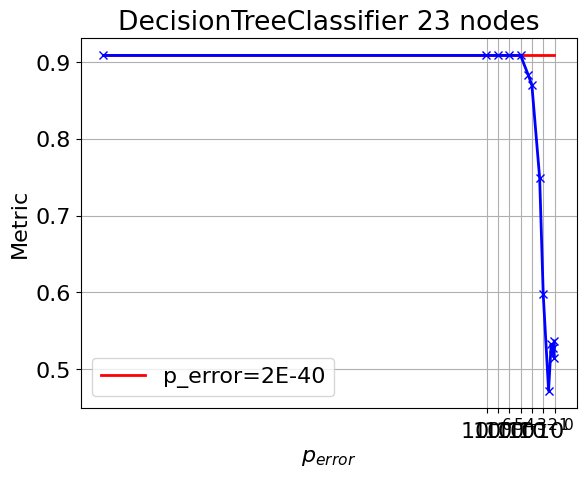

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


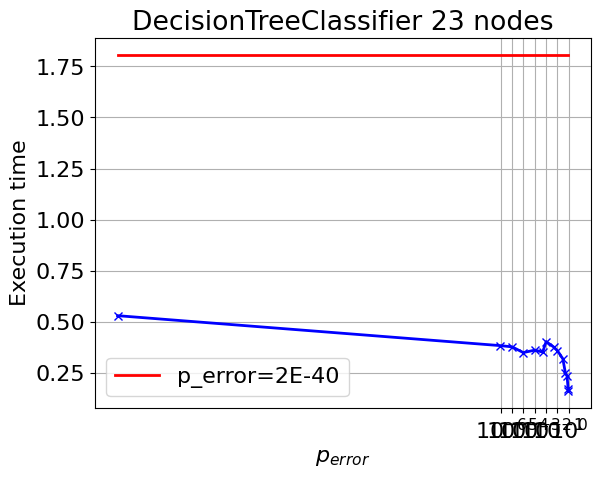

In [9]:
def plot_metrics_vs_error_rates(
    metric_values, model_name, num_nodes, xlabel, ylabel, filename, red_line_value
):
    """Plot the metrics against error rates."""
    plt.figure()
    plt.plot(
        [real_p_error_list[0], real_p_error_list[-1]],
        [red_line_value, red_line_value],
        color="red",
        linewidth=2,
        label="p_error=2E-40",
    )
    plt.plot(real_p_error_list, metric_values, color="blue", linewidth=2, marker="x")
    plt.grid(True)
    plt.legend()
    plt.title(f"{model_name} {num_nodes} nodes")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.semilogx()
    plt.xticks(10.0 ** np.arange(-6, 1))
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.show()


# Plotting accuracy vs error rates
plot_metrics_vs_error_rates(
    acc_scores,
    "DecisionTreeClassifier",
    num_nodes,
    "$p_{error}$",
    "Metric",
    "DecisionTreeClassifier" + "acc_p_error.eps",
    0.91,
)

# Plotting execution time per data point vs error rates
plot_metrics_vs_error_rates(
    np.asarray(time_p_error) / X_test.shape[0],
    "DecisionTreeClassifier",
    num_nodes,
    "$p_{error}$",
    "Execution time",
    "DecisionTreeClassifier" + "speed_p_error.eps",
    1.807,
)

# Speed vs bitwidth

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ap relative: [0.49626943 0.70187731 0.82640876 0.89067066 0.98315255 1.02264581
 1.02436888 1.01090038 1.01268386], f1_relative: [0.06488922 0.65490682 0.87590196 0.90861806 0.97920588 1.00604989
 1.00914511 1.00274636 1.00389957]


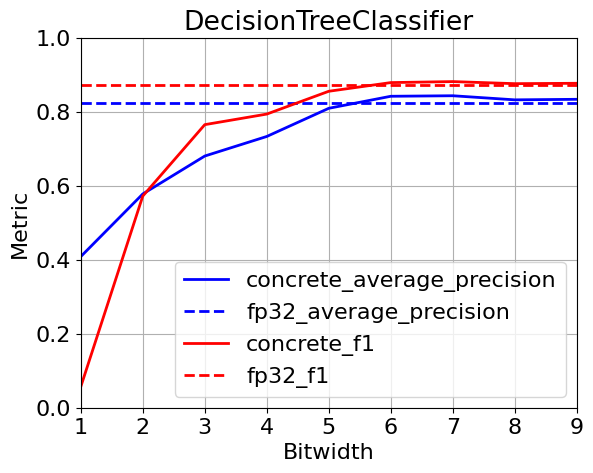

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ap relative: [0.43556747 0.69054787 0.87885097 0.94192257 0.97097036 0.99094624
 0.99348364 0.99626825 0.99932372], f1_relative: [0.         0.65970362 0.91404942 0.95773723 0.97789164 0.99281277
 0.99447789 0.99697611 0.99969255]


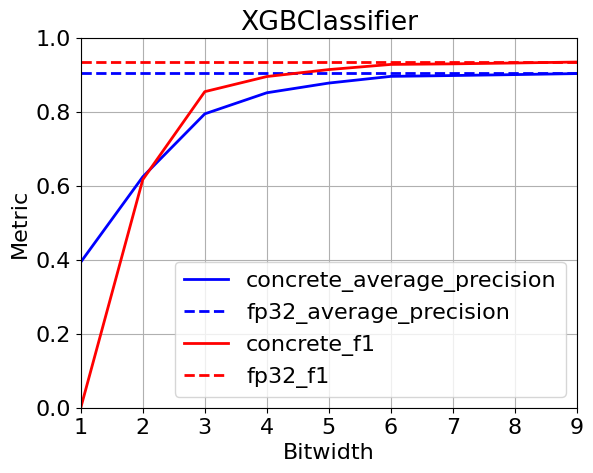

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ap relative: [0.45810941 0.66176353 0.85701522 0.93668402 0.96541385 0.98353791
 0.99091316 0.99133601 0.99740638], f1_relative: [0.         0.57332946 0.87035559 0.9402579  0.96505021 0.983713
 0.99082334 0.99224022 0.99758998]


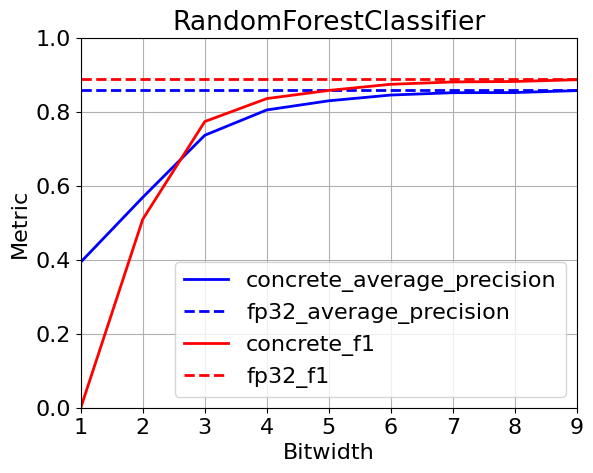

In [10]:
# Plot the metrics vs n_bits for each model
plt.rcParams.update({"font.size": 16})
for cls in model_hyperparameters:
    plt.figure()

    f1_scores = []
    f1_scores_fp32 = []

    average_precision_scores = []
    average_precision_scores_fp32 = []

    for n_bits in n_bits_list:
        average_precision_scores.append(
            np.mean(scores_global[n_bits][cls.__name__ + "_concrete"]["average_precision"])
        )
        average_precision_scores_fp32.append(
            np.mean(scores_global[n_bits][cls.__name__ + "_fp32"]["average_precision"])
        )

        f1_scores.append(np.mean(scores_global[n_bits][cls.__name__ + "_concrete"]["f1"]))
        f1_scores_fp32.append(np.mean(scores_global[n_bits][cls.__name__ + "_fp32"]["f1"]))

    # plt.legend()
    ap_relative = np.array(average_precision_scores) / average_precision_scores_fp32
    f1_relative = np.array(f1_scores) / f1_scores_fp32
    print(f"ap relative: {ap_relative}, f1_relative: {f1_relative}")
    plt.plot(
        n_bits_list,
        average_precision_scores,
        label="concrete_average_precision",
        color="blue",
        linewidth=2,
    )
    plt.plot(
        n_bits_list,
        average_precision_scores_fp32,
        label="fp32_average_precision",
        color="blue",
        linewidth=2,
        linestyle="dashed",
    )

    plt.plot(n_bits_list, f1_scores, label="concrete_f1", linewidth=2, color="red")
    plt.plot(
        n_bits_list, f1_scores_fp32, label="fp32_f1", color="red", linewidth=2, linestyle="dashed"
    )

    plt.grid(True)
    plt.xlim([1, 9])
    plt.ylim([0, 1])
    plt.xticks(np.arange(1, 10))
    plt.legend()

    plt.title(cls.__name__)
    plt.xlabel("Bitwidth")
    plt.ylabel("Metric")
    # Save the figure
    plt.savefig(cls.__name__ + ".eps", bbox_inches="tight", dpi=300)

    plt.show()

In [11]:
def predict_with_fhe(clf, X_sample):
    """Predict using FHE and return elapsed time."""
    print("Compiling and keygen...")
    clf.compile(X_sample[:100])
    clf.fhe_circuit.keygen(force=False)

    print("Predict in FHE")
    start_time = time.time()
    _ = clf.predict(X_sample[:1], fhe="execute")
    end_time = time.time()

    return end_time - start_time


def analyze_and_store(clf, X_sample, nodes_dict, scores_dict):
    """Analyze the model and store results."""
    elapsed_time = predict_with_fhe(clf, X_sample)

    model_name = clf.__class__.__name__
    if model_name not in nodes_dict:
        nodes_dict[model_name] = []
        scores_dict[model_name] = []

    scores_dict[model_name].append(elapsed_time)

    shapes = analyze_gemm_computation(clf)
    nodes_dict[model_name].append(shapes[0][0])

    print(clf.n_bits)
    print(scores_dict[model_name][-1])
    print(nodes_dict[model_name][-1])


X, y = datasets["spambase"]["X"], datasets["spambase"]["y"]
nodes_dict = {}
scores_dict = {}

for model_name, hyperparameters in model_hyperparameters.items():
    for n_bits in n_bits_list:
        clf = model_name(n_bits=n_bits, **hyperparameters)
        clf.fit(X, y)

        if n_bits < 9:
            analyze_and_store(clf, X, nodes_dict, scores_dict)

Compiling and keygen...


Predict in FHE
{'op_inputs': 1, 'op_leaves': 1}
0.2700986862182617
8
Compiling and keygen...


Predict in FHE
{'op_inputs': 2, 'op_leaves': 2}
0.39208316802978516
20
Compiling and keygen...


Predict in FHE
{'op_inputs': 3, 'op_leaves': 3}
0.3580749034881592
20
Compiling and keygen...


Predict in FHE
{'op_inputs': 4, 'op_leaves': 4}
0.5496320724487305
21
Compiling and keygen...


Predict in FHE
{'op_inputs': 5, 'op_leaves': 5}
0.7474322319030762
25
Compiling and keygen...


Predict in FHE
{'op_inputs': 6, 'op_leaves': 6}
0.7431790828704834
23
Compiling and keygen...


Predict in FHE
{'op_inputs': 7, 'op_leaves': 7}
0.7407987117767334
24
Compiling and keygen...


Predict in FHE
{'op_inputs': 8, 'op_leaves': 8}
0.7283117771148682
22


Compiling and keygen...
Predict in FHE
{'op_inputs': 1, 'op_leaves': 1}
0.006150007247924805
200


Compiling and keygen...


Predict in FHE
{'op_inputs': 2, 'op_leaves': 2}
0.2766602039337158
350


Compiling and keygen...


Predict in FHE
{'op_inputs': 3, 'op_leaves': 3}
0.2365860939025879
350


Compiling and keygen...


Predict in FHE


{'op_inputs': 4, 'op_leaves': 4}
0.7464447021484375
350


Compiling and keygen...


Predict in FHE
{'op_inputs': 5, 'op_leaves': 5}
0.87453293800354
350


Compiling and keygen...


Predict in FHE
{'op_inputs': 6, 'op_leaves': 6}
1.2005808353424072
350


Compiling and keygen...


Predict in FHE
{'op_inputs': 7, 'op_leaves': 7}
1.038048267364502
350


Compiling and keygen...


Predict in FHE
{'op_inputs': 8, 'op_leaves': 8}
1.038971185684204
350


Compiling and keygen...


Predict in FHE
{'op_inputs': 1, 'op_leaves': 1}
0.3975186347961426
400


Compiling and keygen...


Predict in FHE
{'op_inputs': 2, 'op_leaves': 2}
0.5555496215820312
650


Compiling and keygen...


Predict in FHE
{'op_inputs': 3, 'op_leaves': 3}
0.5620152950286865
700


Compiling and keygen...


Predict in FHE
{'op_inputs': 4, 'op_leaves': 4}
1.464113473892212
750


Compiling and keygen...


Predict in FHE
{'op_inputs': 5, 'op_leaves': 5}
1.6315643787384033
750


Compiling and keygen...


Predict in FHE
{'op_inputs': 6, 'op_leaves': 6}
1.969606637954712
750


Compiling and keygen...


Predict in FHE
{'op_inputs': 7, 'op_leaves': 7}
2.1223647594451904
750


Compiling and keygen...


Predict in FHE
{'op_inputs': 8, 'op_leaves': 8}
2.2870354652404785
750


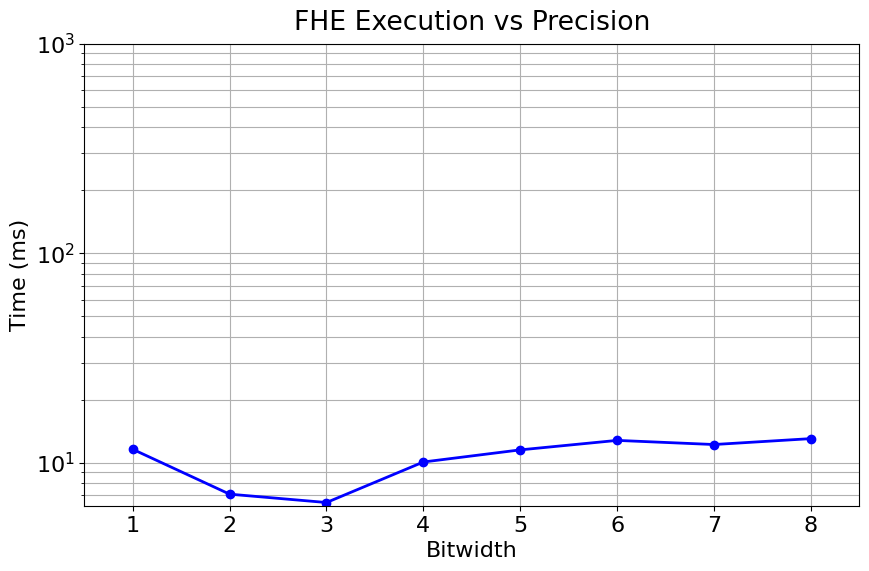

In [12]:
def plot_fhe_inference_time(n_bits_list, scores, model_hyperparameters):
    """Plot the FHE inference time against bitwidth for each model."""

    # Calculate average inference time per node for each bitwidth
    n_bits_timings = np.zeros((8,))
    for model in model_hyperparameters:
        for idx, n_bits in enumerate(n_bits_list):
            if n_bits < 9:
                n_bits_timings[idx] += (
                    scores[model.__name__][idx] / nodes_dict[model.__name__][idx] * 1000
                )
    n_bits_timings /= len(model_hyperparameters)

    # Plot setup
    plt.figure(figsize=(10, 6))
    plt.rcParams.update({"font.size": 16})

    plt.plot(
        range(1, 9),
        n_bits_timings,
        label="FHE Inference Time",
        color="blue",
        linewidth=2,
        marker="o",
    )

    plt.xlabel("Bitwidth")
    plt.ylabel("Time (ms)")
    plt.grid(True, which="both")
    plt.semilogy()
    plt.ylim([0, 1000])
    plt.xlim([0.5, 8.5])
    plt.xticks(np.arange(1, 9))
    plt.title("FHE Execution vs Precision", pad=10)

    plt.savefig("fhe_inference_time.eps", bbox_inches="tight", dpi=300)
    plt.show()


plot_fhe_inference_time(n_bits_list, scores_dict, model_hyperparameters)